In [ ]:
import torch
from src.models import EncoderTransformer
from src.data import random_values, create_signals, sine, remove_samples
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")
cmap = sns.color_palette("Paired")
light_blue = cmap[0]
blue = cmap[1]
purple = cmap[9]

In [ ]:
MAX_SEQUENCE_LENGTH = 512

def create_model(device):
    return EncoderTransformer(
        output_parameter_count=MAX_SEQUENCE_LENGTH,
        d_model=256,
        num_heads=16,
        num_layers=3,
        d_ff=512,
        max_seq_length=MAX_SEQUENCE_LENGTH,
        dropout=0
    ).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
TIME_STEP = 0.5 / MAX_SEQUENCE_LENGTH
MIN_OMEGA = 80
MAX_OMEGA = 120
HOLE_WIDTH = 50
HOLE_COUNT = 2

def create_data(count: int):
    frequencies_1 = random_values(count, MIN_OMEGA, MAX_OMEGA)
    frequencies_2 = random_values(count, MIN_OMEGA, MAX_OMEGA)
    
    phases_1 = random_values(count, 0, 2 * torch.pi)
    phases_2 = random_values(count, 0, 2 * torch.pi)
            
    sine_1 = create_signals(
        omegas=frequencies_1,
        signal_function=sine,
        length=MAX_SEQUENCE_LENGTH,
        time_step=TIME_STEP,
        phases=phases_1
    )

    sine_2 = create_signals(
        omegas=frequencies_2,
        signal_function=sine,
        length=MAX_SEQUENCE_LENGTH,
        time_step=TIME_STEP,
        phases=phases_2
    )

    signals = (sine_1 + sine_2) / 2
    signals_with_missing = remove_samples(signals, HOLE_WIDTH, HOLE_COUNT)
    return signals_with_missing, signals

In [ ]:
best_model = create_model(device)
best_model.eval()
best_model.load_state_dict(torch.load("models/missing-value-imputer.pt", map_location=device))

<All keys matched successfully>

In [10]:
EVAL_COUNT = 6_400
BATCH_SIZE = 128

eval_values, eval_parameters = create_data(EVAL_COUNT)

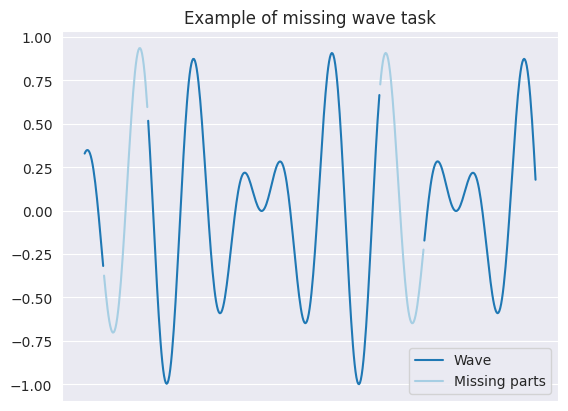

In [ ]:
index = 0

plt.plot(eval_values[index].masked_fill(eval_values[index] == -1e9, np.nan), color=blue, label="Wave")
plt.plot(eval_parameters[index].masked_fill(eval_values[index] != -1e9, np.nan), color=light_blue, label="Missing parts")
plt.title("Example of missing wave task")
plt.xticks([], [])
plt.legend()
plt.savefig("missing_value_imputation_task.png")
plt.show()

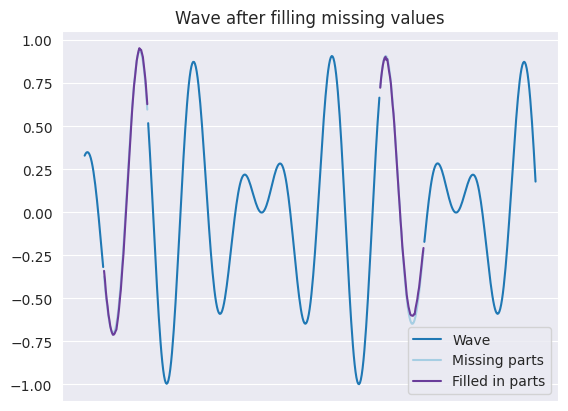

In [ ]:
index = 0

with torch.no_grad():
    pred = best_model(eval_values[index].to(device)).cpu().flatten()

plt.plot(eval_values[index].masked_fill(eval_values[index] == -1e9, np.nan), color=blue, label="Wave")
plt.plot(eval_parameters[index].masked_fill(eval_values[index] != -1e9, np.nan), color=light_blue, label="Missing parts")
plt.plot(pred.masked_fill(eval_values[index] != -1e9, np.nan), color=purple, label="Filled in parts")
plt.title("Wave after filling missing values")
plt.xticks([], [])
plt.legend()
plt.savefig("missing_value_imputation_example.png")
plt.show()

In [ ]:
def missing_value_loss(with_missing: torch.Tensor, actual: torch.Tensor, prediction: torch.Tensor):
    """
    Averages the loss on the masked out values
    """
    count = (with_missing == -1e9).sum()
    diff = (prediction - actual).abs()
    diff = diff.masked_fill(with_missing != -1e9, 0)
    return diff.sum() / count

In [23]:
losses = torch.empty(EVAL_COUNT)
for i in range(EVAL_COUNT):
    with torch.no_grad():
        pred = best_model(eval_values[i].to(device)).cpu().flatten()
    losses[i] = missing_value_loss(eval_values[i], eval_parameters[i], pred)

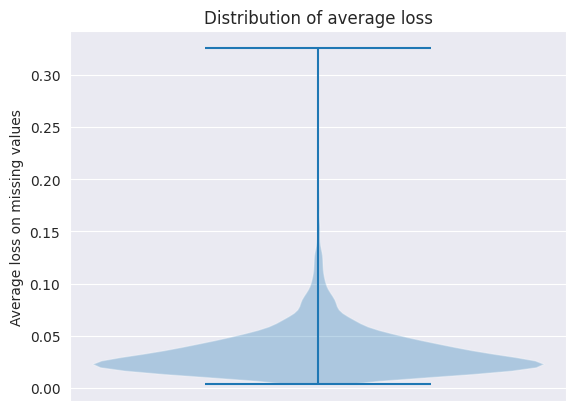

In [30]:
plt.violinplot(losses)
plt.title("Distribution of average loss")
plt.ylabel("Average loss on missing values")
plt.xticks([], [])
plt.savefig("missing_value_imputation_loss.png")
plt.show()